In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay


In [14]:
df = pd.read_csv(r"C:\Users\pavan\Downloads\Telegram Desktop\adult 3.csv")
df.replace('?', np.nan, inplace=True)
df.dropna(inplace=True)
df.drop(['education', 'fnlwgt'], axis=1, inplace=True)
df = df[df['occupation'] != 'Never-worked']


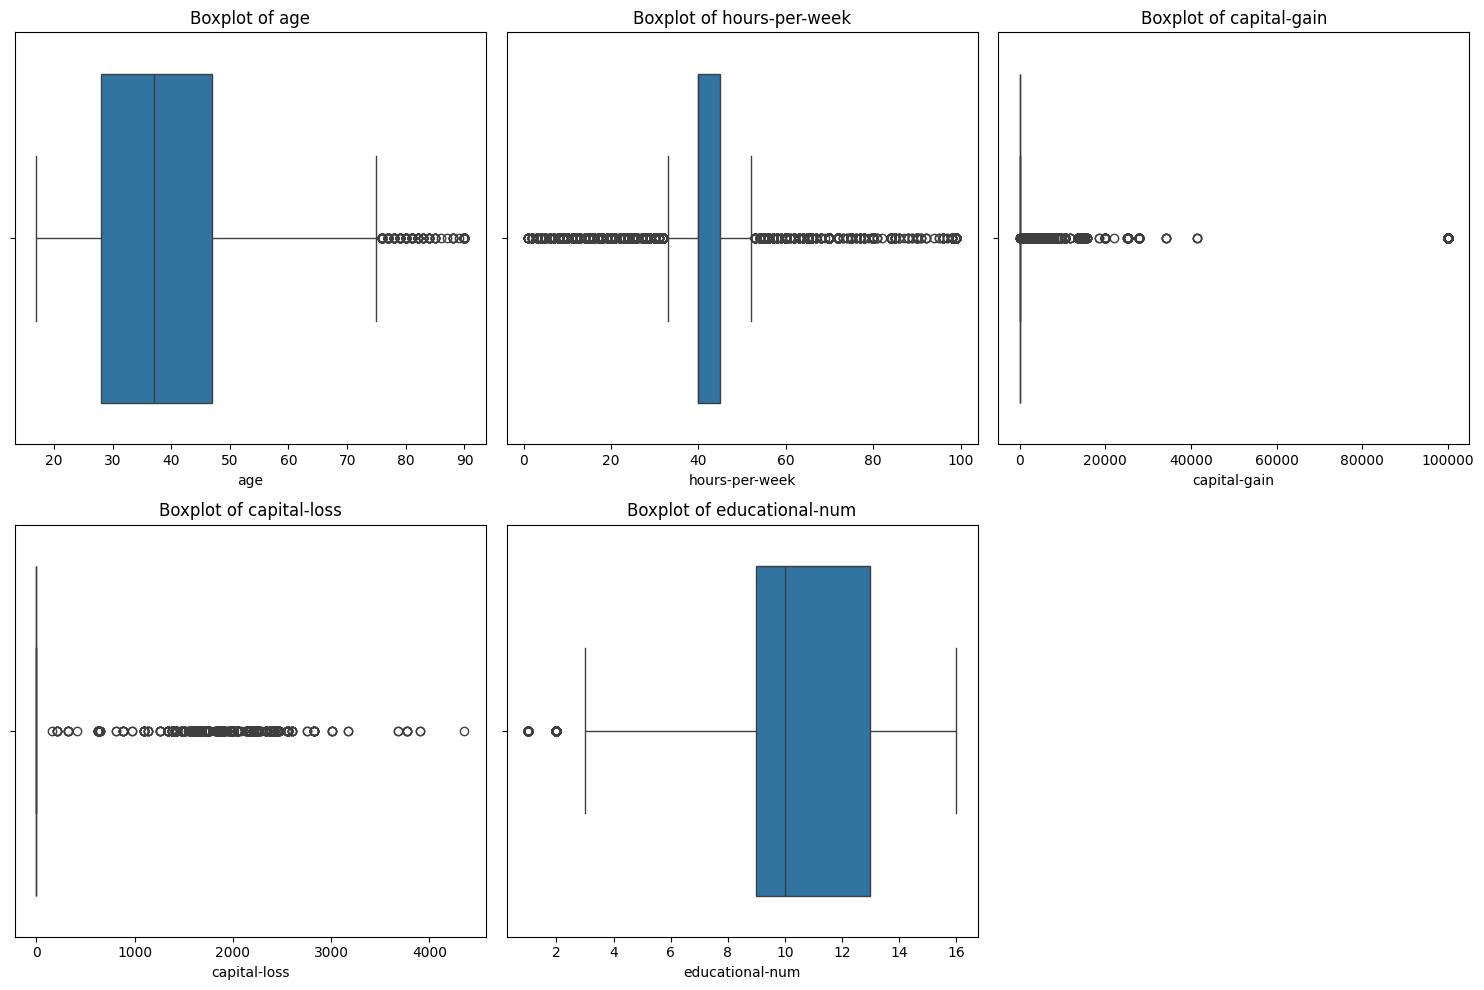

In [15]:
#OUTLIER DETECTION - BOX PLOTS

numerical_cols = ['age', 'hours-per-week', 'capital-gain', 'capital-loss', 'educational-num']

plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(data=df, x=col)
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

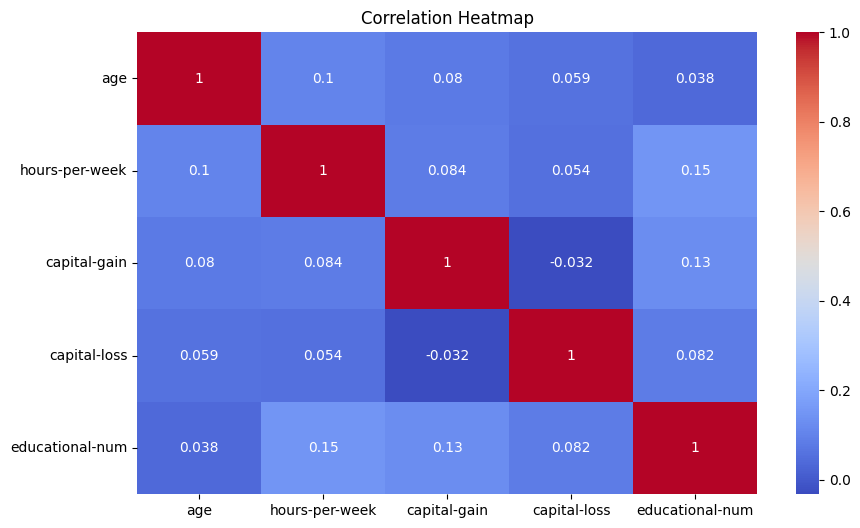

In [16]:
#CORRELATION HEATMAP

plt.figure(figsize=(10, 6))
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

In [17]:
#DATA SPLIT & TRANSFORMATION

X = df.drop('income', axis=1)
y = df['income']

categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

In [18]:
#PIPELINE & MODEL

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier())
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

pipeline.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [19]:
#EVALUATION

y_pred = pipeline.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8685461580983969

Classification Report:
               precision    recall  f1-score   support

       <=50K       0.88      0.95      0.92      6842
        >50K       0.81      0.60      0.69      2203

    accuracy                           0.87      9045
   macro avg       0.85      0.78      0.80      9045
weighted avg       0.86      0.87      0.86      9045



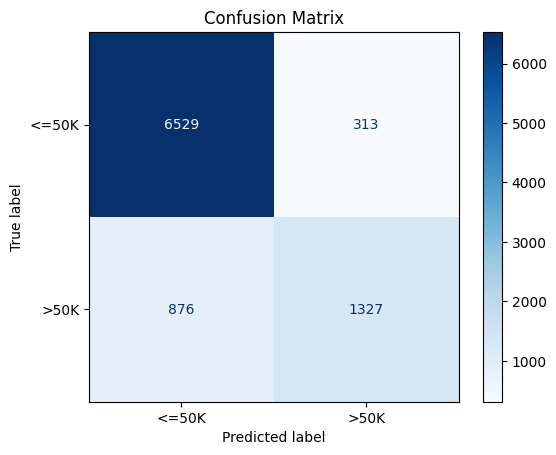

In [20]:
#CONFUSION MATRIX

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

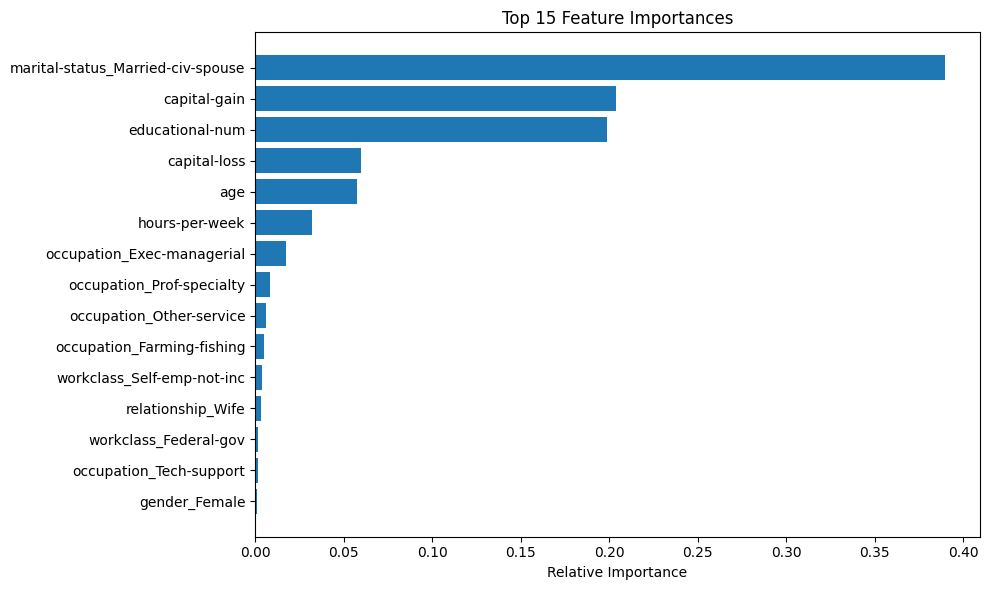

In [22]:
#FEATURE IMPORTANCE
model = pipeline.named_steps['classifier']
ohe = pipeline.named_steps['preprocessor'].named_transformers_['cat']
ohe_features = ohe.get_feature_names_out(categorical_cols)
all_features = np.concatenate([numerical_cols, ohe_features])

importances = model.feature_importances_
indices = np.argsort(importances)[-15:]

plt.figure(figsize=(10, 6))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [all_features[i] for i in indices])
plt.xlabel("Relative Importance")
plt.title("Top 15 Feature Importances")
plt.tight_layout()
plt.show()

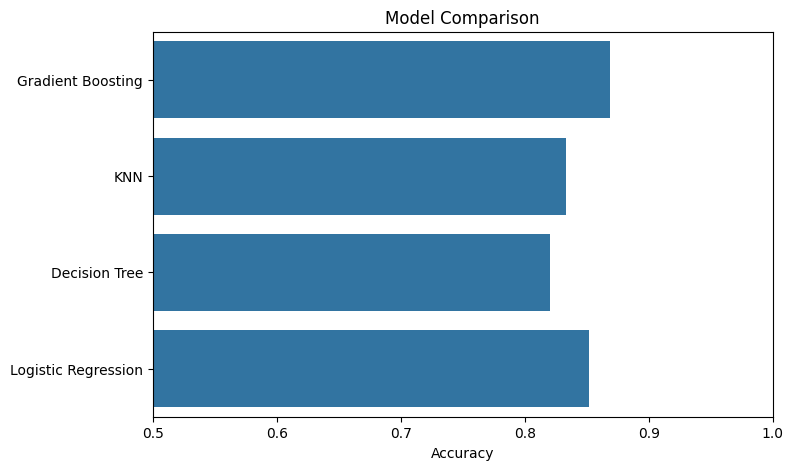

In [23]:
#MODEL COMPARISON
# ================================
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

models = {
    "Gradient Boosting": GradientBoostingClassifier(),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Logistic Regression": LogisticRegression(max_iter=1000)
}

scores = {}
for name, clf in models.items():
    pipe = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', clf)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    scores[name] = acc

plt.figure(figsize=(8, 5))
sns.barplot(x=list(scores.values()), y=list(scores.keys()))
plt.xlabel("Accuracy")
plt.title("Model Comparison")
plt.xlim(0.5, 1.0)
plt.show()

In [25]:
import streamlit as st
import pandas as pd
import joblib

# Load trained model
model = joblib.load("salary_prediction_model.pkl")  # Make sure this model matches your input schema

st.set_page_config(page_title="Employee Salary Classification", page_icon="💼", layout="centered")

st.title("💼 Employee Salary Classification App")
st.markdown("Predict whether an employee earns >50K or ≤50K based on input features.")

# Sidebar Inputs
st.sidebar.header("📋 Input Employee Details")

age = st.sidebar.slider("Age", 18, 65, 30)
education = st.sidebar.selectbox("Education Level", [
    "Bachelors", "HS-grad", "Some-college", "Masters", "Assoc", "PhD"
])
occupation = st.sidebar.selectbox("Occupation", [
    "Tech-support", "Craft-repair", "Other-service", "Sales",
    "Exec-managerial", "Prof-specialty", "Handlers-cleaners", "Machine-op-inspct",
    "Adm-clerical", "Farming-fishing", "Transport-moving", "Priv-house-serv",
    "Protective-serv", "Armed-Forces"
])
hours_per_week = st.sidebar.slider("Hours per week", 1, 80, 40)
capital_gain = st.sidebar.slider("Capital Gain", 0, 10000, 0)
capital_loss = st.sidebar.slider("Capital Loss", 0, 10000, 0)

# Build Input DataFrame
input_df = pd.DataFrame({
    'age': [age],
    'education': [education],
    'occupation': [occupation],
    'hours-per-week': [hours_per_week],
    'capital-gain': [capital_gain],
    'capital-loss': [capital_loss]
})

st.subheader("🔍 Input Preview")
st.write(input_df)

# Prediction Button
if st.button("🎯 Predict Salary Class"):
    prediction = model.predict(input_df)
    st.success(f"✅ Prediction: {prediction[0]}")

# Batch Prediction
st.markdown("---")
st.subheader("📂 Batch Prediction")
uploaded_file = st.file_uploader("Upload a CSV file for batch prediction", type="csv")

if uploaded_file is not None:
    batch_data = pd.read_csv(uploaded_file)
    st.write("Uploaded Data Preview", batch_data.head())
    predictions = model.predict(batch_data)
    batch_data["PredictedClass"] = predictions
    st.write("✅ Batch Predictions", batch_data.head())

    # Download option
    csv = batch_data.to_csv(index=False).encode('utf-8')
    st.download_button("📥 Download Prediction CSV", csv, "salary_predictions.csv", "text/csv") 

FileNotFoundError: [Errno 2] No such file or directory: 'salary_prediction_model.pkl'